# LIM forecasting: multivariate separate sic each month

Katie Brennan  
started November 2020  
  
#### Goals: 
* Build a LIM based on SIC 
* Build a LIM based on both SIC and SIT 
* Compare performance

In [1]:
import sys,os
#sys.path.append("/Users/hakim/gitwork/LMR_python3")
sys.path.append("/home/disk/kalman2/mkb22/pyLMR/")
import LMR_utils

In [2]:
# number of EOFs to retain for the LIM state vector
ntrunc = 400 # EOF truncation for individual fields (reduced-state space)
nmodes = 30 # number of coupled EOFs for LIM state space (truncated-state space)
#nmodes = 25
nmodes_sic = 30
#modes_sic = 20

# forecast lead time in months that defines the LIM training
tau = 1

# training data defined by the first ntrain times
# fraction of years used in training
# ensures that start year of both train and validation data is january 
ntrain = 0.60

# variables to include in the LIM (note "vars" is a Python command)
#limvars = ['tas','zg']
#limvars = ['tas','rlut','zg']
#limvars = ['sic']
#limvars = ['tas','sic']
#limvars = ['tas','sic','zg','psl','pr','tos']
#limvars = ['tas','psl','tos','sit','sic']
limvars = ['tas','psl','sit','sic']
nvars = len(limvars)

# specify the model source 
train_dsource = 'mpi_lm'
#train_dsource = 'ccsm4_lm'
valid_dsource = 'mpi_lm'

sic_separate = True

In [3]:
'_'.join(limvars)

'tas_psl_sit_sic'

In [4]:
full_names = {'tas':'Surface air temperature',
              'psl':'Sea level Pressure',
              'sic':'Sea ice concentration', 
              'sit':'Sea ice thickness',
              'tos':'Sea surface temperature',
              'zg': '500hPa geopotential height'}

In [5]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.util import add_cyclic_point
from collections import OrderedDict 

import scipy as spy

In [6]:
arc_proj = dict(projection=ccrs.Stereographic(central_latitude=90,
                                              central_longitude=-45,
                                              true_scale_latitude=0.1))
proj = dict(projection=ccrs.Robinson(central_longitude=0.),zorder=1)

In [7]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")
import LIM_utils as lim

In [8]:
import importlib
importlib.reload(lim)

<module 'LIM_utils' from '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_utils.py'>

In [9]:
from datetime import date

today = date.today()

#Year-month-day
today_date = today.strftime("%Y%m%d")

In [10]:
import time as timestamp # avoids conflict with local naming!

In [11]:
pi = np.pi

# fill continents if plotting SST; otherwise no
# if var_to_extract == 'tos':
#     noland = True
# else:
#     noland = False

infile_20cr_tas = '/home/disk/kalman3/rtardif/LMR/data/model/20cr/tas_sfc_Amon_20CR_185101-201112.nc'

fdic_ccsm4 = lim.build_training_dic(train_dsource)
fdic_mpi = lim.build_training_dic(valid_dsource)

In [12]:
#----------- end of function definitions --------------

In [13]:
#
# load training data...
var_dict = {}
#
for k, var in enumerate(limvars): 
    print('Loading '+var)
    data_in,lat_2d,lon_2d, time_yrs = lim.get_data(var,fdic_mpi[var], 45, 72, regrid=False)
    ntime = data_in.shape[0]
    nlat = data_in.shape[1]
    nlon = data_in.shape[2]
    ndof = nlat*nlon
    X_var = np.moveaxis(np.reshape(data_in,[ntime,ndof]),0,-1) 
    
    # save location indices for each variable
    d = {}
#    var_inds = np.arange(0,ndof)
#    fields[limvars[k]] = var_inds
    d['varind'] = k
    d['lat'] = lat_2d
    d['lon'] = lon_2d
    d['var_ndof'] = ndof
    var_dict[var] = d
    
#     if k == 0: 
#         X_all = np.zeros((nvars,nlat*nlon,ntime))
#     X_all[k,:,:] = X_var

    if k == 0: 
        X_all = X_var
    else: 
        X_all = np.concatenate((X_all,X_var),axis=0)

Loading tas
fetching  tas  from  /home/disk/kalman3/rtardif/LMR/data/model/mpi-esm-p_last_millenium/tas_sfc_Amon_MPI-ESM-P_past1000_085001-185012.nc
-----------------------------------------------------
completed in 16.578728437423706 seconds
-----------------------------------------------------
(12000, 96, 192)
indlat= 0  indlon= 1
('lat', 'lon')
skipping regridding...
Removing climo from:
month = 0
month = 1
month = 2
month = 3
month = 4
month = 5
month = 6
month = 7
month = 8
month = 9
month = 10
month = 11
Loading psl
fetching  psl  from  /home/disk/kalman3/rtardif/LMR/data/model/mpi-esm-p_last_millenium/psl_sfc_Amon_MPI-ESM-P_past1000_085001-185012.nc
-----------------------------------------------------
completed in 14.441513061523438 seconds
-----------------------------------------------------
(12000, 96, 192)
indlat= 0  indlon= 1
('lat', 'lon')
skipping regridding...
Removing climo from:
month = 0
month = 1
month = 2
month = 3
month = 4
month = 5
month = 6
month = 7
month = 8


In [14]:
start=0
for k,var in enumerate(limvars):
    nvar = var_dict[var]['varind']
    var_dof = var_dict[var]['var_ndof']
    
    var_dict[var]['var_inds'] = np.arange(start,start+var_dof)
    start = start + var_dof

In [15]:
#
# load different validation data...
#
# for k, var in enumerate(limvars): 
#     print('Loading '+var)
#     [data_in_mpi,lat_2d_mpi,
#      lon_2d_mpi, time_yrs_mpi] = lim.get_data(var,fdic_mpi[var], 45, 72)
#     ntime_mpi = data_in_mpi.shape[0]
#     nlat_mpi = data_in_mpi.shape[1]
#     nlon_mpi = data_in_mpi.shape[2]
#     X_var_mpi = np.moveaxis(np.reshape(data_in_mpi,[ntime_mpi,nlat_mpi*nlon_mpi]),0,-1) 
#     if k == 0: 
#         X_all_mpi = np.zeros((nvars,nlat_mpi*nlon_mpi,ntime_mpi))
#     X_all_mpi[k,:,:] = X_var_mpi

In [16]:
# combine fields in the row space into a full state vector
# if nvars > 1:
#     for k in range(nvars-1):
#         if k == 0:
#             X = np.concatenate((X_all[0],X_all[1]),axis=0)
# #            X_mpi = np.concatenate((X_all_mpi[0],X_all_mpi[1]),axis=0)
#         else:
#             X = np.concatenate((X,X_all[k+1]),axis=0)
# #            X_mpi = np.concatenate((X_mpi,X_all_mpi[k+1]),axis=0)
# else:
#     X = np.squeeze(np.copy(X_all))
# #    X_mpi = np.squeeze(np.copy(X_all_mpi))
    
# print(X.shape)
# #print(X_mpi.shape)

In [15]:
# prepare the data to train and test the LIM. 
# separate data into training the validation sets 
mo = 1
tsamp = X_all.shape[1]
nyears_train = int((tsamp*ntrain)/12)
#nyears_valid = int(X_all_mpi.shape[2]/12)
nyears_valid = int((tsamp*(1-ntrain))/12)

X_t = np.reshape(X_all,(X_all.shape[0],int(tsamp/12),12))
X_train = X_t[:,0:nyears_train,mo]
X_train2 = X_t[:,0:nyears_train,mo+1]
X_valid = X_t[:,nyears_train:,mo]
truth = X_t[:,nyears_train:,mo+1]

yrs_mo = np.reshape(time_yrs,(int(tsamp/12),12))

yrs_train = yrs_mo[0:nyears_train,mo]
yrs_valid = yrs_mo[nyears_train:,mo+1]

# X_train = np.reshape(X_t,(X_all.shape[0],X_all.shape[1],nyears_train*2))
# X_valid = np.reshape(X_all_mpi,(X_all_mpi.shape[0],X_all_mpi.shape[1],
#                                 nyears_valid,12))[:,:,:,mo]
# truth = np.reshape(X_mpi,(X_mpi.shape[0],nyears_valid,12))[:,:,mo+1]

# yrs_train = np.reshape(time_yrs,(nyears_train,12))
# yrs_valid = np.reshape(time_yrs_mpi,(nyears_valid,12))

print('training data shape: ',X_train.shape)
print('validation data shape: ',X_valid.shape)
print('truth data shape: ',truth.shape)

training data shape:  (149504, 600)
validation data shape:  (149504, 400)
truth data shape:  (149504, 400)


In [323]:
nmodes_sic

30

In [16]:
# SINGLE VARIABLE EOF DECOMPOSITION:
ndof = var_dict['sic']['var_ndof']
tmp = np.sqrt(np.cos(np.deg2rad(var_dict['sic']['lat'])))
W = np.reshape(tmp,[ndof,1])

x_test = X_train[var_dict['sic']['var_inds']]
inp = W*np.nan_to_num(x_test)
nt = inp.shape[1]

u,s,v = np.linalg.svd(inp,full_matrices=False)

eofs_out = u[:,:nmodes_sic]
svals_out = s[:nmodes_sic]
pcs_out = v[:nmodes_sic]

eig_vals = (svals_out**2)/nt
total_var = np.nanvar(x_test,ddof=1,axis=1).sum()
var_expl_by_mode = eig_vals/total_var
var_expl_by_retained = var_expl_by_mode.sum()

# compress original field:
P_test = np.matmul(eofs_out.T,W*np.nan_to_num(x_test))
#standard_factor = np.sqrt(total_var)
standard_factor = np.sqrt(np.sum(np.nanvar(P_test,axis=1)))
#standard_factor = np.sqrt((np.nanvar(P_test,axis=1)))

P_trunc = P_test/standard_factor

# Decompress original field: 
x_trunc = np.matmul(eofs_out*standard_factor, P_trunc)

In [17]:
np.corrcoef(x_test[0,:],x_trunc[0,:])[0,1]**2

0.9578540899981961

In [18]:
ii=50
#plt.plot((x_trunc/W)[:,0], label='truncated ')
#plt.plot((x_test)[:,0], label='original')
plt.plot((x_trunc/W)[ii,:], label='truncated ')
plt.plot((x_test)[ii,:], label='original')
plt.legend()

NameError: name 'ii' is not defined

In [332]:
np.var((x_trunc/W)[ii,:])/np.var((x_test)[ii,:])

0.9470384246810135

In [16]:
ndof = var_dict['tas']['var_ndof']
tmp = np.sqrt(np.cos(np.deg2rad(var_dict['tas']['lat'])))
W = np.reshape(tmp,[ndof,1])

x_test = X_train[var_dict['tas']['var_inds']]
inp = W*(x_test)
nt = inp.shape[1]

In [17]:
u.shape

NameError: name 'u' is not defined

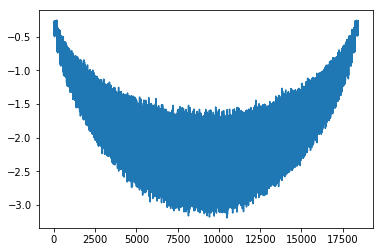

In [18]:
plt.plot(inp[:,0])

In [116]:
u,s,v = np.linalg.svd(inp,full_matrices=False)

In [147]:
np.sum(s[:ntrunc]*s[:ntrunc])/np.sum(s*s)

0.9998820080042898

In [145]:
inp.shape
eig_vals = (s[:ntrunc]**2)/inp.shape[1]
total_var = x_test.var(ddof=1,axis=1).sum()
var_expl_by_retained = (eig_vals/total_var).sum()
var_expl_by_retained 

0.6616841025495992

In [139]:
total_var , (s[:ntrunc]**2).sum(), eig_vals.sum()

(21853.775, 8676177.453999732, 14460.295756666223)

In [21]:
# compress original field:
P_test = np.matmul(u.T,(W*x_test))

# Decompress original field: 
x_trunc = np.matmul(u, P_test)

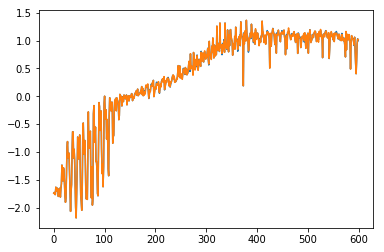

In [184]:
plt.plot((x_trunc/W)[0,:])
plt.plot(x_test[0,:])

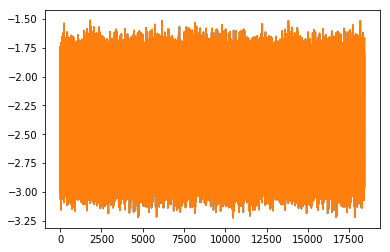

In [225]:
plt.plot((x_trunc/W)[:,0])
plt.plot(x_test[:,0])

In [53]:
def compress_individual_vars(X_train, limvars, ntrunc, nmodes_sic, var_dict, 
                             X_allshape, X_sicshape, sic_separate=False): 
    
    nvars = len(limvars)
    
    if sic_separate is True: 
        E3 = np.zeros([X_allshape-X_sicshape,ntrunc*(nvars-1)])
    else:  
        E3 = np.zeros([X_allshape,ntrunc*(nvars)])
    n=0
    W_all = np.zeros((X_allshape))

    for k,var in enumerate(limvars):
        print('decomposing...',var)
        # weight matrix for equal-area covariance normalization
        ndof = var_dict[var]['var_ndof']
        u,s,v,W = eof_decomp_1var(X_train[var_dict[var]['var_inds'],:],var_dict[var]['lat'],
                                  ndof,sic_separate=sic_separate)
        W_all[var_dict[var]['var_inds']] = np.squeeze(W)
        
        fvar = 100*s*s/np.sum(s*s)
        if (sic_separate is True) & (var is 'sic'):
            print('fraction in first '+str(nmodes_sic)+ ' '+limvars[k]+' EOFs = ',np.sum(fvar[:nmodes_sic]))
        else: 
            print('fraction in first '+str(ntrunc)+ ' '+limvars[k]+' EOFs = ',np.sum(fvar[:ntrunc]))

        # projection
        P_var = np.matmul(u[:,:ntrunc].T,np.nan_to_num(X_train[var_dict[var]['var_inds'],:]))
        standard_factor = np.sqrt(np.sum(np.nanvar(P_var,axis=1)))

        if k == 0:
            Ptrunc = P_var/standard_factor

            # reverse operator from EOFs to grid point space
            E3[var_dict[var]['var_inds'],k*ntrunc:(k+1)*ntrunc] = u[:,:ntrunc]*standard_factor
            n=n+1
        elif (sic_separate is True) & (var is 'sic'):
            print('...separately')
            Ptrunc_sic = np.matmul(u[:,:nmodes_sic].T,
                                   np.nan_to_num(X_train[var_dict[var]['var_inds'],:]))/standard_factor
            E_sic = u[:,:nmodes_sic]*standard_factor
        else:
            Ptrunc = np.concatenate((Ptrunc,P_var/standard_factor),axis=0)

            # reverse operator from EOFs to grid point space
            E3[var_dict[var]['var_inds'],n*ntrunc:(n+1)*ntrunc] = u[:,:ntrunc]*standard_factor
            n=n+1
    if sic_separate is True: 
        return Ptrunc, E3, Ptrunc_sic, E_sic, W_all, standard_factor
    else: 
        return Ptrunc, E3, W_all, standard_factor


In [152]:
def eof_decomp_1var(X,lat,ndof,ntime,ntrunc,sic_separate=False, Weight=True): 
    """
    INPUTS: 
    X = (ndof, ntime)
    late
    """
    
    if Weight is True: 
        tmp = np.sqrt(np.cos(np.deg2rad(lat)))
        W = np.reshape(tmp,[ndof,1])
        inp = W*np.nan_to_num(X)
        
    else: 
        inp = np.nan_to_num(X)

    u,s,v = np.linalg.svd(inp,full_matrices=False)

    eofs_out = u[:,:ntrunc]
    svals_out = s[:ntrunc]
    pcs_out = v[:ntrunc]

    eig_vals = (svals_out**2)
    total_var = np.nanvar(X,ddof=1,axis=1).sum()
    var_expl_by_retained = 100*np.sum(eig_vals)/np.sum(s*s)
    
    return eofs_out, svals_out, pcs_out, total_var, var_expl_by_retained, W

In [333]:
def compress_individual_vars2(X_train, limvars, ntrunc, nmodes_sic, var_dict, 
                              X_allshape, X_sicshape, sic_separate=False): 
    
    nvars = len(limvars)
    W_all = {}
    standard_factor = {}
    
    if sic_separate is True: 
        E3 = np.zeros([X_allshape-X_sicshape,ntrunc*(nvars-1)])
    else:  
        E3 = np.zeros([X_allshape,ntrunc*(nvars)])
    n=0

    for k,var in enumerate(limvars):
        print('decomposing...',var)
        # weight matrix for equal-area covariance normalization
        ndof = var_dict[var]['var_ndof']
        ntime = X_train.shape[1]
        LAT = var_dict['tas']['lat']
        
        if (sic_separate is True) & (var is 'sic'):
            trunc = nmodes_sic
        else: 
            trunc = ntrunc
        
        [eofs_out, svals_out, pcs_out, 
         total_var, var_expl_by_retained, W] = eof_decomp_1var(X_train[var_dict[var]['var_inds'],:],
                                                               var_dict[var]['lat'],ndof,ntime,trunc,
                                                               sic_separate=False,Weight=True)
        W_all[var] = np.squeeze(W)
        
        if (sic_separate is True) & (var is 'sic'):
            print('fraction in first '+str(nmodes_sic)+ ' '+limvars[k]+' EOFs = '+str(var_expl_by_retained))
        else: 
            print('fraction in first '+str(ntrunc)+ ' '+limvars[k]+' EOFs = '+str(var_expl_by_retained))


        if k == 0:
            # projection
            P_var = np.matmul(eofs_out.T,W*np.nan_to_num(X_train[var_dict[var]['var_inds'],:]))
            standard_factor[var] = np.sqrt(np.sum(np.nanvar(P_var,axis=1)))
            
            Ptrunc = P_var/standard_factor[var]

            # reverse operator from EOFs to grid point space
            E3[var_dict[var]['var_inds'],k*ntrunc:(k+1)*ntrunc] = eofs_out*standard_factor[var]
            n=n+1
        elif (sic_separate is True) & (var is 'sic'):
            print('...separately')
            Pvar_sic = np.matmul(eofs_out.T,W*np.nan_to_num(X_train[var_dict[var]['var_inds'],:]))
            standard_factor[var] = np.sqrt(np.sum(np.nanvar(Pvar_sic,axis=1)))
            
            Ptrunc_sic = Pvar_sic/standard_factor[var]
            E_sic = eofs_out*standard_factor[var]
        else:
            # projection
            P_var = np.matmul(eofs_out.T,W*np.nan_to_num(X_train[var_dict[var]['var_inds'],:]))
            standard_factor[var] = np.sqrt(np.sum(np.nanvar(P_var,axis=1)))
            
            Ptrunc = np.concatenate((Ptrunc,P_var/standard_factor[var]),axis=0)

            # reverse operator from EOFs to grid point space
            E3[var_dict[var]['var_inds'],n*ntrunc:(n+1)*ntrunc] = eofs_out*standard_factor[var]
            n=n+1
    if sic_separate is True: 
        return Ptrunc, E3, Ptrunc_sic, E_sic, W_all, standard_factor
    else: 
        return Ptrunc, E3, W_all, standard_factor

In [150]:
standard_factor = {}

ndof = var_dict['tas']['var_ndof']
ntime = X_train.shape[1]
LAT = var_dict['tas']['lat']

[eofs_out, svals_out, pcs_out, 
 total_var, var_expl_by_retained, W] = eof_decomp_1var(X_train[var_dict['tas']['var_inds'],:],LAT,ndof,ntime,
                                                       ntrunc,sic_separate=False, Weight=True)

# compress original field:
P_test = np.matmul(eofs_out.T,W*np.nan_to_num(x_test))
#standard_factor = np.sqrt(total_var)
standard_factor['tas'] = np.sqrt(np.sum(np.nanvar(P_test,axis=1)))
#standard_factor = np.sqrt((np.nanvar(P_test,axis=1)))

P_trunc = P_test/standard_factor['tas']

In [97]:
# Decompress original field: 
x_trunc = np.matmul(eofs_out, P_trunc)*standard_factor

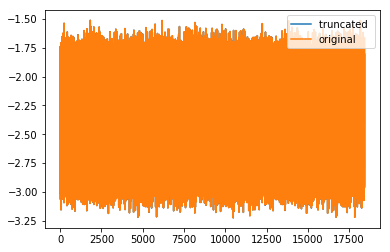

In [98]:
plt.plot((x_trunc/W)[:,0], label='truncated ')
plt.plot((x_test)[:,0], label='original')
plt.legend()

In [338]:
# PH approach: coupled-EOFs in truncated EOF space. 

# weight matrix for equal-area covariance normalization
# tmp = np.sqrt(np.cos(np.radians(lat_2d)))
# W = np.reshape(tmp,[nlat*nlon,1])
# # note W*X = X*W

[Ptrunc, E3, Ptrunc_sic, 
 E_sic, W_train, sf_train] = compress_individual_vars2(X_train, limvars, ntrunc, nmodes_sic, var_dict, 
                                                      X_all.shape[0], var_dict['sic']['var_ndof'], 
                                                      sic_separate=sic_separate)
    
# truncate the coupled covariance matrix
U,S,V = np.linalg.svd(Ptrunc,full_matrices=False)
Etrunc = U[:,0:nmodes]

Fvar = 100*S*S/np.sum(S*S)
print('Fraction in first '+str(nmodes)+ ' multivariate EOFs = ',np.sum(Fvar[:nmodes]))

P = np.matmul(Etrunc.T,Ptrunc)
# reverse operator from *truncated* EOF space to full grid point space
E = np.matmul(E3,Etrunc)
print('Shape of E: '+ str(E.shape))

if sic_separate is True: 
    P_train = np.concatenate((P,Ptrunc_sic),axis=0)
#    E_train = np.concatenate((E,E_sic),axis=1)
else: 
    P_train = P

decomposing... tas
fraction in first 400 tas EOFs = 99.98820080042898
decomposing... psl
fraction in first 400 psl EOFs = 99.83906784475552
decomposing... sit
fraction in first 400 sit EOFs = 99.99999282817843
decomposing... sic
fraction in first 30 sic EOFs = 96.1434382480135
...separately
Fraction in first 30 multivariate EOFs =  94.51726448650527
Shape of E: (93184, 30)


In [341]:
x_train_dcomp = decompress_eof_separate_sic2(P_train,nmodes,nmodes_sic,E,E_sic,
                                             limvars,var_dict,W_train,Weights=True)

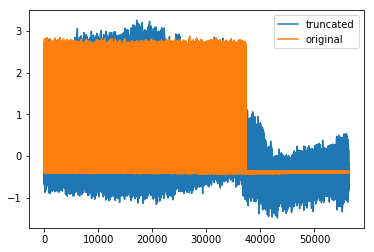

In [345]:
ii=10
var = 'sic'
x_decomp = x_train_dcomp[var_dict[var]['var_inds']]

plt.plot(x_decomp[:,ii], label='truncated')
#plt.plot((sic_train_dcomp)[ii,:], label='truncated')
plt.plot((X_train[var_dict[var]['var_inds']])[:,ii], label='original')
#plt.plot((x_trunc/W)[:,0], label='truncated2 ')
#plt.xlim(0,200)
plt.legend()

In [317]:
var = 'sic'

[eofs_out, svals_out, pcs_out, 
 total_var, var_expl_by_retained, W] = eof_decomp_1var(X_train[var_dict[var]['var_inds'],:],
                                                       var_dict[var]['lat'],X_train[var_dict[var]['var_inds'],:].shape[0],
                                                       ntime,nmodes_sic,
                                                       sic_separate=False,Weight=True)
W_all_sic = np.squeeze(W)

if (sic_separate is True) & (var is 'sic'):
    print('fraction in first '+str(nmodes_sic)+ ' '+limvars[k]+' EOFs = '+str(var_expl_by_retained))
else: 
    print('fraction in first '+str(ntrunc)+ ' '+limvars[k]+' EOFs = '+str(var_expl_by_retained))

# projection
P_var = np.matmul(eofs_out.T,W*np.nan_to_num(X_train[var_dict[var]['var_inds'],:]))
standard_factor_sic = np.sqrt(np.sum(np.nanvar(P_var,axis=1)))

if k == 0:
    Ptrunc = P_var/standard_factor[var]

    # reverse operator from EOFs to grid point space
    E3[var_dict[var]['var_inds'],k*ntrunc:(k+1)*ntrunc] = eofs_out*standard_factor[var]
    n=n+1
elif (sic_separate is True) & (var is 'sic'):
    print('...separately')
    Pvar_sic = np.matmul(eofs_out.T,W_all_sic[:,np.newaxis]*np.nan_to_num(X_train[var_dict[var]['var_inds'],:]))
    standard_factor_sic = np.sqrt(np.sum(np.nanvar(Pvar_sic,axis=1)))
    
    Ptrunc_sic = Pvar_sic/standard_factor_sic
    E_sic = eofs_out*standard_factor_sic
else:
    Ptrunc = np.concatenate((Ptrunc,P_var/standard_factor[var]),axis=0)

    # reverse operator from EOFs to grid point space
    E3[var_dict[var]['var_inds'],n*ntrunc:(n+1)*ntrunc] = eofs_out*standard_factor[var]
    n=n+1


fraction in first 30 sic EOFs = 96.1434382480135
...separately


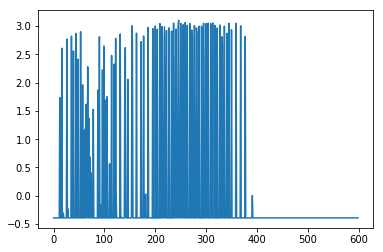

In [311]:
ii=450
#plt.plot((X_train[var_dict['sic']['var_inds']])[:,ii]-(X_train[var_dict['sic']['var_inds']])[:,ii+10])
#plt.plot((X_train[var_dict['sic']['var_inds']])[:,ii+10])
plt.plot((X_train[var_dict['sic']['var_inds']])[ii,:])
#plt.xlim(0,100)

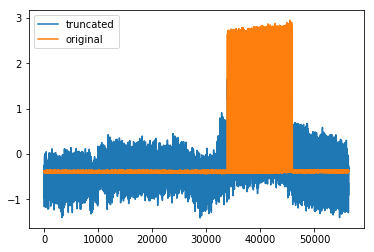

In [376]:
ii=14
sic_train_dcomp = np.matmul(E_sic, Ptrunc_sic)

plt.plot((sic_train_dcomp/W_all_sic[:,np.newaxis])[:,ii], label='truncated')
#plt.plot((sic_train_dcomp)[ii,:], label='truncated')
plt.plot((X_train[var_dict['sic']['var_inds']])[:,ii], label='original')
#plt.plot((x_trunc/W)[:,0], label='truncated2 ')
#plt.xlim(0,200)
plt.legend()

In [380]:
var_dict['sic']['lat'].shape

(220, 256)

In [383]:
test_plot = np.reshape((X_train[var_dict['sic']['var_inds']])[:,ii],
                       (var_dict['sic']['lat'].shape[0],var_dict['sic']['lat'].shape[1]))

fig,ax = plt.subplots(2,len(limvars), figsize=(10,5),proj=arc_proj)
lim.sub_arctic_plot(ax,fig,test_plot,var_dict['sic']['lat'],var_dict['sic']['lon'],maxv=-1,
                    minv=-1,colorbar=True,extent=True,cmap='bwr'):

### MAKE SURE: the decompression code is doing what's done below. 

In [337]:
def decompress_eof_separate_sic2(P_train,nmodes,nmodes_sic,E,E_sic,
                                 limvars,var_dict,W_all,Weights=True):
    x_multivar = P_train[0:nmodes,:]
    x_sic = P_train[-nmodes_sic:,:]

    x_train_multi_dcomp = np.matmul(E,x_multivar)
    x_train_sic_dcomp = np.matmul(E_sic,x_sic)
    x_train_dcomp = np.concatenate((x_train_multi_dcomp,x_train_sic_dcomp),axis=0)
    
    if Weights is True: 
        X_train_dcomp = unweight_decompressed_vars(x_train_dcomp, limvars, var_dict, W_all)
    else: 
        X_train_dcomp = x_train_dcomp
    
    return X_train_dcomp

In [334]:
def unweight_decompressed_vars(x_train_dcomp, limvars, var_dict, W_all):
    X_out = np.zeros_like(x_train_dcomp)
    
    for var in (limvars):
        inds = var_dict[var]['var_inds']
        X_out[inds,:] = x_train_dcomp[inds,:]/W_all[var][:,np.newaxis]
        
    return X_out

In [ ]:
plt.plot()

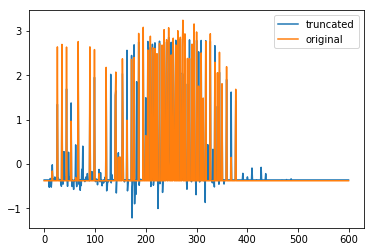

In [269]:
ii = 100
x_train_dcomp = np.matmul(E, P_train[0:nmodes,:])
sic_train_dcomp = np.matmul(E_sic, P_train[-nmodes_sic:,:])
#plt.plot((x_train_dcomp[var_dict['tas']['var_inds']]/W_train['tas'][:,np.newaxis])[:,0])
#
#plt.plot((X_train[var_dict['sic']['var_inds']])[ii,:], label='original')
#plt.plot((x_train_dcomp[var_dict['sic']['var_inds']]/W_train['sit'][:,np.newaxis])[100,:], label='truncated')
plt.plot((sic_train_dcomp/W_train['sic'][:,np.newaxis])[ii,:], label='truncated')
plt.plot((X_train[var_dict['sic']['var_inds']])[ii,:], label='original')

#plt.xlim(100,200)
plt.legend()

In [258]:
var_dict['psl']['var_inds'], X_train.shape

(array([18432, 18433, 18434, ..., 36861, 36862, 36863]), (149504, 600))

In [267]:
((x_train_dcomp[var_dict['sit']['var_inds']]/W_train['sit'][:,np.newaxis])[100,:]).var()/X_train[var_dict['sit']['var_inds']][100,:].var()

0.9182591191724186

In [193]:
# PH approach: coupled-EOFs in truncated EOF space. 

# weight matrix for equal-area covariance normalization
# tmp = np.sqrt(np.cos(np.radians(lat_2d)))
# W = np.reshape(tmp,[nlat*nlon,1])
# # note W*X = X*W

# [Ptrunc, E3, Ptrunc_sic, 
#  E_sic, W_train, sf_train] = compress_individual_vars(X_train, limvars, ntrunc, nmodes_sic, var_dict, 
#                                           X_all.shape[0], var_dict['sic']['var_ndof'], 
#                                           sic_separate=sic_separate)
    
# # truncate the coupled covariance matrix
# U,S,V = np.linalg.svd(Ptrunc,full_matrices=False)
# Etrunc = U[:,0:nmodes]

# Fvar = 100*S*S/np.sum(S*S)
# print('Fraction in first '+str(nmodes)+ ' multivariate EOFs = ',np.sum(Fvar[:nmodes]))

# P = np.matmul(Etrunc.T,Ptrunc)
# # reverse operator from *truncated* EOF space to full grid point space
# E = np.matmul(E3,Etrunc)
# print('Shape of E: '+ str(E.shape))

# if sic_separate is True: 
#     P_train = np.concatenate((P,Ptrunc_sic),axis=0)
# #    E_train = np.concatenate((E,E_sic),axis=1)
# else: 
#     P_train = P

In [192]:
[Ptrunc2, E3_2, Ptrunc_sic2, 
 E_sic2, W_train2, sf_train2] = compress_individual_vars2(X_train2, limvars, ntrunc, nmodes_sic, var_dict, 
                                                          X_all.shape[0], var_dict['sic']['var_ndof'], 
                                                          sic_separate=sic_separate)
    
# truncate the coupled covariance matrix
U2,S2,V2 = np.linalg.svd(Ptrunc,full_matrices=False)
Etrunc2 = U[:,0:nmodes]

Fvar2 = 100*S*S/np.sum(S*S)
print('Fraction in first '+str(nmodes)+ ' multivariate EOFs = ',np.sum(Fvar[:nmodes]))

P2 = np.matmul(Etrunc.T,Ptrunc)
# reverse operator from *truncated* EOF space to full grid point space
E2 = np.matmul(E3,Etrunc)
print('Shape of E: '+ str(E.shape))

if sic_separate is True: 
    P_train2 = np.concatenate((P,Ptrunc_sic),axis=0)
#    E_train = np.concatenate((E,E_sic),axis=1)
else: 
    P_train2 = P2

decomposing... tas
fraction in first 400 tas EOFs = 99.98828108065526
decomposing... psl
fraction in first 400 psl EOFs = 99.83936248821973
decomposing... sit
fraction in first 400 sit EOFs = 100.00000714329492
decomposing... sic
fraction in first 30 sic EOFs = 96.07956577573918
...separately
Fraction in first 30 multivariate EOFs =  94.51726448650527
Shape of E: (93184, 30)


In [194]:
[Ptrunc_valid, E3_valid, Ptrunc_sic_valid, 
 E_sic_valid, W_valid, sf_valid] = compress_individual_vars2(X_valid, limvars, ntrunc, nmodes_sic, var_dict, 
                                                             X_all.shape[0], var_dict['sic']['var_ndof'], 
                                                             sic_separate=sic_separate)
    
# truncate the coupled covariance matrix
U,S,V = np.linalg.svd(Ptrunc_valid,full_matrices=False)
Etrunc_valid = U[:,0:nmodes]
P_valid = np.matmul(Etrunc_valid.T,Ptrunc_valid)

Fvar = 100*S*S/np.sum(S*S)
print('Fraction in first '+str(nmodes)+ ' multivariate EOFs = ',np.sum(Fvar[:nmodes]))

# reverse operator from *truncated* EOF space to full grid point space
E_valid = np.matmul(E3_valid,Etrunc_valid)
print('Shape of E_valid: '+ str(E_valid.shape))

if sic_separate is True: 
    P_valid = np.concatenate((P_valid,Ptrunc_sic_valid),axis=0)
#    E_train = np.concatenate((E,E_sic),axis=1)
else: 
    P_valid = P_valid

decomposing... tas
fraction in first 400 tas EOFs = 100.0
decomposing... psl
fraction in first 400 psl EOFs = 100.0
decomposing... sit
fraction in first 400 sit EOFs = 100.0
decomposing... sic
fraction in first 30 sic EOFs = 94.63438272439363
...separately
Fraction in first 30 multivariate EOFs =  88.59531831560814
Shape of E_valid: (93184, 30)


In [195]:
# prepare the data to train and test the LIM. 
# separate data into training the validation sets 
tsamp = X_all.shape[1]
nyears = tsamp/12
ntrain_yrs = int(np.floor((tsamp/12)*ntrain)*12)
train_inds = np.arange(0,ntrain_yrs)
valid_inds = np.arange(ntrain_yrs,tsamp,1)

x_train = P_train
x_train2 = P_train2
x_valid = P_valid

# if sic_separate is True: 
#     nonsic = X_valid[:var_dict['sic']['var_inds'][0],:]
#     x_valid_nonsic = np.matmul(E_valid.T,np.nan_to_num(nonsic))
#     x_valid_sic = np.matmul(E_sic_valid.T,np.nan_to_num(X_valid[var_dict['sic']['var_inds'],:]))
#     x_valid = np.concatenate((x_valid_nonsic,x_valid_sic),axis=0)
# else: 
#     x_valid =  np.matmul(E_valid.T,np.nan_to_num(X_valid))

print('training data shape: ',x_train.shape)
print('validation data shape: ',x_valid.shape)

training data shape:  (60, 600)
validation data shape:  (60, 400)


In [196]:
# climo standardized variance for error normalization 
#  in training and validation (1=no skill)
# EOF space only
if sic_separate is True: 
    E_x_train = lim.decompress_eof_separate_sic(x_train,nmodes,nmodes_sic,E,E_sic)
    E_x_valid = lim.decompress_eof_separate_sic(x_valid,nmodes,nmodes_sic,E_valid,E_sic_valid)

else: 
    E_x_train = np.matmul(E,x_train)
    E_x_valid = np.matmul(E_valid,x_valid)

E_x_train[np.isclose(E_x_train,0,atol=10e-10)] = np.nan
E_x_valid[np.isclose(E_x_valid,0,atol=10e-10)] = np.nan
    
nyrs_train = int(E_x_train.shape[1]/12)
nyrs_valid = int(E_x_valid.shape[1]/12)
nlalo = E_x_train.shape[0]

# train_var_mon = np.nanvar(np.reshape(E_x_train,(nlalo,nyrs_train,12)),
#                        axis=1,ddof=1)
# valid_var_mon = np.nanvar(np.reshape(E_x_valid,(nlalo,nyrs_valid,12)),
#                        axis=1,ddof=1)
train_var = np.nanvar(E_x_train,axis=1,ddof=1)
valid_var = np.nanvar(E_x_valid,axis=1,ddof=1)

# FULL FIELD versions of the variance 
train_var_full = np.nanvar(X_train,axis=1,ddof=1)
valid_var_full = np.nanvar(X_valid,axis=1,ddof=1)

# valid_var_mon_full = np.var(np.reshape(X_mpi,(nvars*ndof,nyrs_valid,12)),
#                             axis=1,ddof=1)

In [197]:
(E_x_train/W_train[:,np.newaxis]).shape

TypeError: unhashable type: 'slice'

TypeError: unhashable type: 'slice'

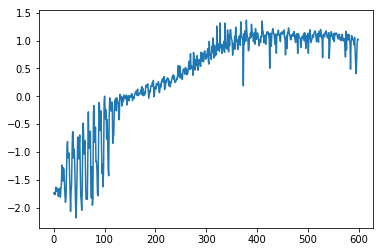

In [198]:
pt = 0
plt.plot(X_train[pt,:], label = 'X - original')
plt.plot((E_x_train/W_train[:,np.newaxis])[pt,:], label='X - truncated')
#plt.plot(E_x_train[pt,:]/(W_all[pt]), label='X - truncated, unweighted')
plt.legend()
#plt.xlim(0,200)

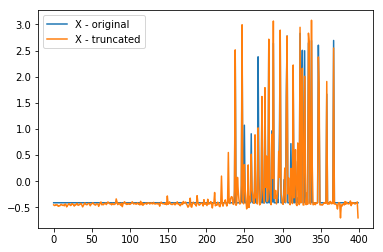

In [199]:
pt = 100000
plt.plot(X_valid[pt,:], label = 'X - original')
plt.plot(E_x_valid[pt,:], label='X - truncated')
#plt.xlim(0,50)
plt.legend()

In [137]:
# # valid_variance_eof = lim.calc_gm_polar_variance(valid_var,valid_var_mon,
# #                                                 fields,lat_2d[:,0],lon_2d[0,:])
# valid_variance_full = lim.calc_gm_polar_variance(valid_var_full,valid_var_mon_full,
#                                                  fields,lat_2d[:,0],lon_2d[0,:])

# for v,var in enumerate(limvars):
#     print(var)
# #    valid_variance_eof[var+'_lalo'] = np.reshape(valid_var[fields[var]],[nlat,nlon])
#     valid_variance_full[var+'_lalo'] = np.reshape(valid_var_full[fields[var]],[nlat,nlon])
# #    valid_variance_eof[var+'_mon_lalo'] = np.reshape(valid_var_mon[fields[var]],
# #                                                     [nlat,nlon,12])
# #     valid_variance_full[var+'_mon_lalo'] = np.reshape(valid_var_mon_full[fields[var]],
# #                                                       [nlat,nlon,12])

In [49]:
# train the LIM
LIMd, G = lim.LIM_train(tau,x_train)
print('Training LIM with tau = '+str(tau))

Training LIM with tau = 1


In [202]:
#x_train_mon = np.reshape(x_train,(x_train.shape[0],1001,2))

In [204]:
x_train.shape

(30, 600)

In [51]:
LIMd2, G2 = lim.LIM_train_flex(tau,x_train, x_train2)

In [52]:
# LIM forecasts for a range of monthly values (can specify a list of arbitrary values too)
lags = [1]
#lags = [0,3,6,12]
ntims = len(lags)

# training data
#truth = np.real(np.matmul(E,x_train))
#truth = X[:,train_inds]
#LIMfd_train = LIM_utils.LIM_forecast(LIMd,x_train,lags,E,truth)

# validation data
#truth = np.real(np.matmul(E,x_valid))
LIMfd_valid = lim.LIM_forecast_test(G,x_valid,lags,E_valid,truth,yrs_valid,len(limvars),ndof,
                                    nmodes=nmodes,nmodes_sic=nmodes_sic,E_sic=E_sic_valid,
                                    sic_separate=sic_separate)

t= 1


ValueError: could not broadcast input array from shape (149504) into shape (225280)

In [141]:
truth_state = {}
nlat = lat_2d[:,0].shape[0]
nlon = lon_2d[0,:].shape[0]

for v,var in enumerate(limvars):
    print('working on '+str(var))
    if sic_separate is True: 
        Truth = lim.decompress_eof(truth,E,E_sic=E_sic,
                                   nmodes=nmodes,nmodes_sic=nmodes_sic,
                                   sic_separate=sic_separate)
    else: 
        Truth = np.matmul(E,truth)
#            print(Truth.shape)
    truth_3d = np.reshape(Truth[fields[var],:].T,[Truth.shape[1],nlat,nlon])
    truth_gm,_,_ = LMR_utils.global_hemispheric_means(truth_3d[1:,:,:],lat_2d[:,0])
    truth_pm = lim.polar_regional_means(truth_3d[1:,:,:],lat_2d[:,0],lon_2d[0,:])

    truth_state[var+'_gm_mo_'+str(mo)] = truth_gm
    truth_state[var+'_pm_mo_'+str(mo)] = truth_pm
    truth_state[var+'_full_mo_'+str(mo)] = truth_3d

working on tas
working on psl
working on tos
working on sit
working on sic


In [142]:
LIMfd_valid['x_forecast'].shape

(1, 120, 1000)

In [143]:
forecast = {}

for v,var in enumerate(limvars):
    print('working on '+str(var))
    if sic_separate is True: 
        fcast = lim.decompress_eof(LIMfd_valid['x_forecast'][0,:,:],E,E_sic=E_sic,
                                      nmodes=nmodes,nmodes_sic=nmodes_sic,
                                      sic_separate=sic_separate)
    else: 
        fcast = np.matmul(E,LIMfd_valid['x_forecast'][0,:,:])
#            print(Truth.shape)
    forecast_3d = np.reshape(fcast[fields[var],:].T,[fcast.shape[1],nlat,nlon])
    forecast_gm,_,_ = LMR_utils.global_hemispheric_means(forecast_3d[1:,:,:],lat_2d[:,0])
    forecast_pm = lim.polar_regional_means(forecast_3d[1:,:,:],lat_2d[:,0],lon_2d[0,:])

    forecast[var+'_gm_mo_'+str(mo)] = forecast_gm
    forecast[var+'_pm_mo_'+str(mo)] = forecast_pm
    forecast[var+'_full_mo_'+str(mo)] = forecast_3d

working on tas
working on psl
working on tos
working on sit
working on sic


In [144]:
ce = {}
corr = {}

for n,var in enumerate(limvars):
    print('working on '+str(var))
    ce_pm_lag = np.zeros((2))
    corr_pm_lag = np.zeros((2))

    ce_gm = LMR_utils.coefficient_efficiency(truth_state[var+'_gm_mo_'+str(mo)],
                                                    forecast[var+'_gm_mo_'+str(mo)])
    corr_gm = np.corrcoef(truth_state[var+'_gm_mo_'+str(mo)],
                                 forecast[var+'_gm_mo_'+str(mo)])[0,1]

    for n in range(2):
        ce_pm_lag[n] = LMR_utils.coefficient_efficiency(truth_state[var+'_pm_mo_'+str(mo)][n,:],
                                                          forecast[var+'_pm_mo_'+str(mo)][n,:])
        corr_pm_lag[n] = np.corrcoef(truth_state[var+'_pm_mo_'+str(mo)][n,:],
                                       forecast[var+'_pm_mo_'+str(mo)][n,:])[0,1]

    ce[var+'_gm_mo_'+str(mo)] = ce_gm
    ce[var+'_pm_mo_'+str(mo)] = ce_pm_lag
    corr[var+'_gm_mo_'+str(mo)] = corr_gm
    corr[var+'_pm_mo_'+str(mo)] = corr_pm_lag

working on tas
working on psl
working on tos
working on sit
working on sic


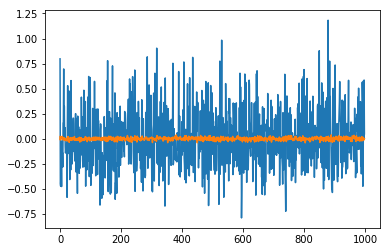

In [148]:
plt.plot(forecast['tas_gm_mo_'+str(mo)])
plt.plot(truth_state['tas_gm_mo_'+str(mo)])

In [145]:
for var in limvars: 
    print(var)
    print('GM CE = '+str(ce[var+'_gm_mo_'+str(mo)])+' GM Corr = '+ str(corr[var+'_gm_mo_'+str(mo)]))

tas
GM CE = -403.25880941645715 GM Corr = -0.024220206464738832
psl
GM CE = -741.4342540101476 GM Corr = -0.055287853100057884
tos
GM CE = -264.07100597064516 GM Corr = -0.03161414428771794
sit
GM CE = -342.94229872323535 GM Corr = -0.04336836101191847
sic
GM CE = -17.072935880843577 GM Corr = -0.019626058348466802


In [38]:
ce_ar1, corr_ar1= lim.calc_ce_corr_ar_lags(X_valid,X_train,lags,limvars,
                                           lat_2d[:,0],lon_2d[0,:])

working on tas
working on psl
working on tos
working on sic


In [39]:
ce_ar1_valid, corr_ar1_valid = lim.calc_ce_corr_ar_lags(X_valid,X_valid,lags,
                                                        limvars,lat_2d[:,0], lon_2d[0,:])

working on tas
working on psl
working on tos


/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_utils.py:797: RuntimeWarning: invalid value encountered in true_divide
  lac = cov / std


working on sic


In [ ]:
X_valid.shape

In [ ]:
Xv.shape

In [112]:
v = 3
var = 'tos'
Xt = X_valid
Xv = X_valid
lat = lat_2d[:,0]
lon = lon_2d[0,:]
l = np.arange(1,2,1)

ar1_gm = np.zeros((len(l),Xv.shape[2]))
ar1_pm = np.zeros((len(l),2,Xv.shape[2]))
ce_pm = np.zeros((len(l),2))
corr_pm = np.zeros((len(l),2))

for i,lag in enumerate(l):
    ar1_forecast, ar1_factor = lim.red_noise_forecast_ar1(Xt[v,:].T,Xv[v,:].T,lead=lag)
    ar1_forecast_3d = np.reshape(ar1_forecast,(ar1_forecast.shape[0],nlat,nlon))
    X_valid_3d = np.reshape(Xv[v,:].T,(Xv.shape[2],nlat,nlon))
    ar1_gm[i,lag:],_,_ = LMR_utils.global_hemispheric_means(ar1_forecast_3d,lat)
    ar1_pm[i,:,lag:] = lim.polar_regional_means(ar1_forecast_3d,lat,lon)

    true_gm,_,_ = LMR_utils.global_hemispheric_means(X_valid_3d,lat)
    true_pm = lim.polar_regional_means(X_valid_3d,lat,lon)

    ce_gm = LMR_utils.coefficient_efficiency(true_gm[lag:],ar1_gm[i,lag:])
    corr_gm = np.corrcoef(true_gm[lag:],ar1_gm[i,lag:])[0,1]
    for n in range(2):
        ce_pm[i,n] = LMR_utils.coefficient_efficiency(true_pm[n,lag:],ar1_pm[i,n,lag:])
        corr_pm[i,n] = np.corrcoef(true_pm[n,lag:],ar1_pm[i,n,lag:])[0,1]

/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_utils.py:793: RuntimeWarning: invalid value encountered in true_divide
  lac = cov / std


In [122]:
np.nanmin(ar1_factor), Xv[v,:].T.shape

(-0.00033366700033366306, (12000, 3240))

In [125]:
ar1_forecast.shape

(11999, 3240)

In [106]:
corr_gm

0.9848644683160668

In [110]:
np.corrcoef(true_gm[1:],ar1_gm[0,1:])[0,1]

0.9848644683160668

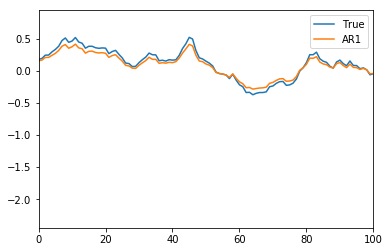

In [108]:
plt.plot(true_gm[1:], label='True')
plt.plot(ar1_gm[0,2:], label='AR1')
plt.xlim(0,100)
plt.legend()

#### check in eof space: 

In [ ]:
truth_eof = np.matmul(E_sic,x_valid_sic)
truth_eof_gm,_,_ = LMR_utils.global_hemispheric_means(np.reshape(truth_eof.T,(7212,45,72)), lat_2d[:,0])

In [ ]:
truth_state['sic_gm'].shape

In [ ]:
plt.plot(truth_state['sic_gm'][0,:],label='truth')
plt.plot(forecast['sic_gm'][0,:],label='forecast')
plt.plot(truth_eof_gm,label='truth eof')
plt.legend()
plt.title('GM SIC')

In [ ]:
k=0
ce_test = LMR_utils.coefficient_efficiency(truth_eof_gm,forecast[var+'_gm'][k,k:])
corr_test = np.corrcoef(truth_eof_gm,forecast[var+'_gm'][k,k:])[0,1]
corr_test, ce_test

In [148]:
corr_ar1_valid['tos_gm']

array([0.        , 0.98486447, 0.96391541, 0.93804171, 0.90800665,
       0.87682375, 0.84661718, 0.81847671, 0.79224612, 0.76764925,
       0.74339473, 0.71778917, 0.69008076])

### Plotting: 

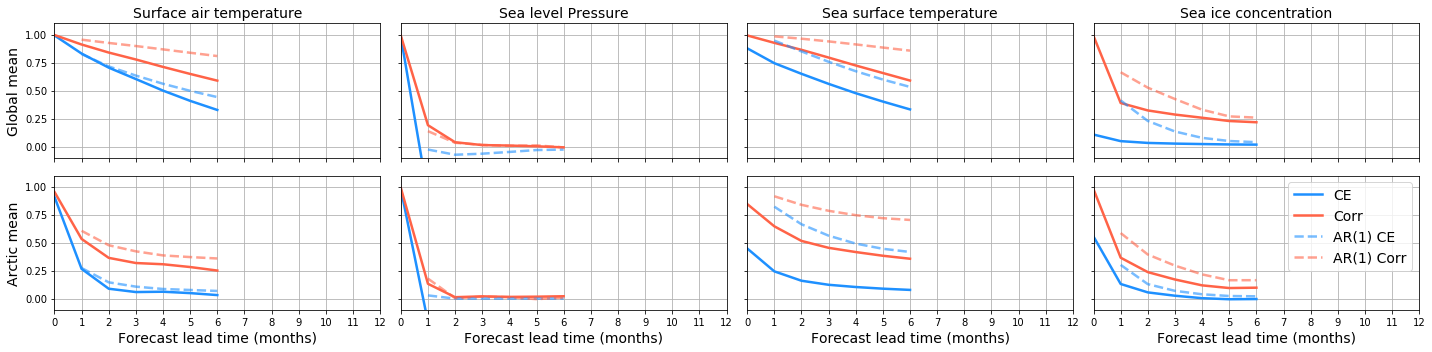

In [48]:
color_list = ['tomato','dodgerblue','m','c','orange','k']

fig,ax = plt.subplots(2,len(limvars), figsize=(20,5),sharex=True, sharey=True)
ax = ax.flatten()

for n,var in enumerate(limvars): 
    ax[n].plot(lags,ce[var+'_gm'],color=color_list[1],
             linestyle='-',linewidth=2.5)
    ax[n].plot(lags,corr[var+'_gm'],color=color_list[0],
             linestyle='-',linewidth=2.5)
    ax[n+len(limvars)].plot(lags,ce[var+'_pm'][:,0],color=color_list[1],
             linestyle='-', label='CE',linewidth=2.5)
    ax[n+len(limvars)].plot(lags,corr[var+'_pm'][:,0],color=color_list[0],
             linestyle='-', label='Corr',linewidth=2.5)
    
for n,var in enumerate(limvars): 
    ax[n].plot(lags[1:],ce_ar1[var+'_gm'][1:],color=color_list[1],
             linestyle='--',alpha=0.6, linewidth=2.5)
    ax[n].plot(lags[1:],corr_ar1[var+'_gm'][1:],color=color_list[0],
             linestyle='--',alpha=0.6, linewidth=2.5)
    ax[n+len(limvars)].plot(lags[1:],ce_ar1[var+'_pm'][1:,0],color=color_list[1],
             linestyle='--',alpha=0.6, linewidth=2.5, label='AR(1) CE')
    ax[n+len(limvars)].plot(lags[1:],corr_ar1[var+'_pm'][1:,0],color=color_list[0],
             linestyle='--',alpha=0.6, linewidth=2.5, label='AR(1) Corr')

ax[0].set_ylabel('Global mean', fontsize=14)
ax[len(limvars)].set_ylabel('Arctic mean', fontsize=14)

for n in np.arange(len(limvars),len(limvars)*2,1):
    ax[n].set_xlabel('Forecast lead time (months)', fontsize=14)
    ax[n].set_xticks(np.arange(0,13,1))

for n,var in enumerate(limvars):
    ax[n].set_title(full_names[var], fontsize=14)

for n in range(2*len(limvars)):
    ax[n].grid(which='both')
    ax[n].set_xlim(0,12)
    ax[n].set_ylim(-0.10,1.1)
plt.xlabel('Forecast lead time (months)', fontsize=14)

ax[7].legend(loc='upper right', fontsize=14)
#ax[-1].legend(bbox_to_anchor=([1,1,0,0]), fontsize=14)
plt.tight_layout()

#fig.set_title('LIM performance')

save_dir = '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/results/CCSM4_training_MPI_valid/'
save_name = ('ce_corr_lags_lim_'+str(train_dsource)+'_'+'_'.join(limvars)+'_valid_'+
             str(valid_dsource)+'_tau_'+str(tau)+'_'+today_date+'.png')
plt.savefig((save_dir+save_name),dpi=300)

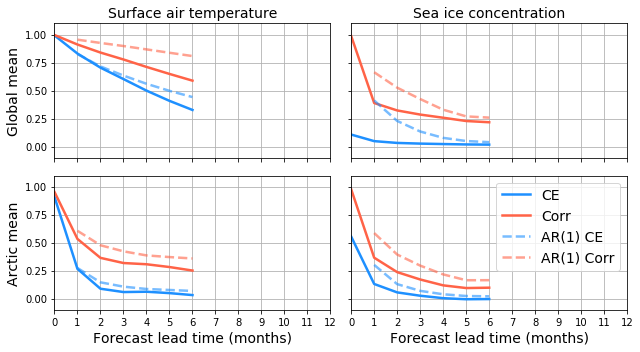

In [49]:
color_list = ['tomato','dodgerblue','m','c','orange','k']
varplot = ['tas','sic']

fig,ax = plt.subplots(2,len(varplot), figsize=(9,5),sharex=True, sharey=True)
ax = ax.flatten()

for n,var in enumerate(varplot): 
    ax[n].plot(lags,ce[var+'_gm'],color=color_list[1],
             linestyle='-',linewidth=2.5)
    ax[n].plot(lags,corr[var+'_gm'],color=color_list[0],
             linestyle='-',linewidth=2.5)
    ax[n+len(varplot)].plot(lags,ce[var+'_pm'][:,0],color=color_list[1],
             linestyle='-', label='CE',linewidth=2.5)
    ax[n+len(varplot)].plot(lags,corr[var+'_pm'][:,0],color=color_list[0],
             linestyle='-', label='Corr',linewidth=2.5)
    
for n,var in enumerate(varplot): 
    ax[n].plot(lags[1:],ce_ar1[var+'_gm'][1:],color=color_list[1],
             linestyle='--',alpha=0.6, linewidth=2.5)
    ax[n].plot(lags[1:],corr_ar1[var+'_gm'][1:],color=color_list[0],
             linestyle='--',alpha=0.6, linewidth=2.5)
    ax[n+len(varplot)].plot(lags[1:],ce_ar1[var+'_pm'][1:,0],color=color_list[1],
             linestyle='--',alpha=0.6, linewidth=2.5, label='AR(1) CE')
    ax[n+len(varplot)].plot(lags[1:],corr_ar1[var+'_pm'][1:,0],color=color_list[0],
             linestyle='--',alpha=0.6, linewidth=2.5, label='AR(1) Corr')

ax[0].set_ylabel('Global mean', fontsize=14)
ax[len(varplot)].set_ylabel('Arctic mean', fontsize=14)

for n in np.arange(len(varplot),len(varplot)*2,1):
    ax[n].set_xlabel('Forecast lead time (months)', fontsize=14)
    ax[n].set_xticks(np.arange(0,13,1))

for n,var in enumerate(varplot):
    ax[n].set_title(full_names[var], fontsize=14)

for n in range(2*len(varplot)):
    ax[n].grid(which='both')
    ax[n].set_xlim(0,12)
    ax[n].set_ylim(-0.10,1.1)
plt.xlabel('Forecast lead time (months)', fontsize=14)

ax[-1].legend(bbox_to_anchor=([1,1,0,0]), fontsize=14)
plt.tight_layout()

In [ ]:
len(limvars)

## Monthly performance: 

In [50]:
ce_monthly = {}
corr_monthly = {}
l = 1

for n,var in enumerate(limvars): 
    ce_pm_mon = np.zeros((12,2))
    corr_pm_mon = np.zeros((12,2))
    ce_gm_mon = np.zeros((12))
    corr_gm_mon = np.zeros((12))
    
    truth_state_mon_gm = np.reshape(truth_state[0][var+'_gm'][1,12:],(nyrs_valid-1,12))
    forecast_mon_gm = np.reshape(forecast[0][var+'_gm'][1,12:],(nyrs_valid-1,12))
    truth_state_mon_pm = np.reshape(truth_state[0][var+'_pm'][1,:,12:],(2,nyrs_valid-1,12))
    forecast_mon_pm = np.reshape(forecast[0][var+'_pm'][1,:,12:],(2,nyrs_valid-1,12))

    for mon in range(12):
        ce_gm_mon[mon] = LMR_utils.coefficient_efficiency(truth_state_mon_gm[:,mon],
                                                          forecast_mon_gm[:,mon])
        corr_gm_mon[mon] = np.corrcoef(truth_state_mon_gm[:,mon],
                                     forecast_mon_gm[:,mon])[0,1]

        for m in range(2):
            ce_pm_mon[mon,m] = LMR_utils.coefficient_efficiency(truth_state_mon_pm[m,:,mon],
                                                              forecast_mon_pm[m,:,mon])
            corr_pm_mon[mon,m] = np.corrcoef(truth_state_mon_pm[m,:,mon],
                                           forecast_mon_pm[m,:,mon])[0,1]

    ce_monthly[var+'_pm'] = ce_pm_mon
    corr_monthly[var+'_pm'] = corr_pm_mon
    ce_monthly[var+'_gm'] = ce_gm_mon
    corr_monthly[var+'_gm'] = corr_gm_mon

In [55]:
ce_mon_ar1, corr_mon_ar1 = lim.calc_ce_corr_ar_mon(X_valid,X_train,1,
                                                   limvars,lat_2d[:,0],lon_2d[0,:])

tas
psl
tos
sic


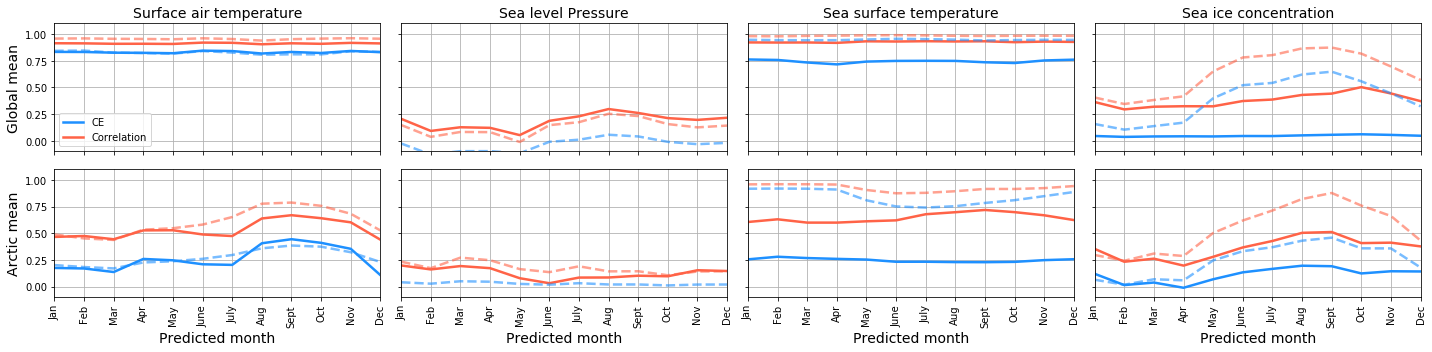

In [58]:
mlabels = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']

fig,ax = plt.subplots(2,len(limvars), figsize=(20,5),sharex=True, sharey=True)
ax = ax.flatten()

for n,var in enumerate(limvars): 
    print(var)
    ax[n].plot(np.arange(1,13,1),ce_monthly[var+'_gm'],color=color_list[1],
             linestyle='-', label='CE', linewidth=2.5)
    ax[n].plot(np.arange(1,13,1),corr_monthly[var+'_gm'],color=color_list[0],
             linestyle='-', label='Correlation', linewidth=2.5)
    ax[n+len(limvars)].plot(np.arange(1,13,1),ce_monthly[var+'_pm'][:,0],color=color_list[1],
             linestyle='-', linewidth=2.5)
    ax[n+len(limvars)].plot(np.arange(1,13,1),corr_monthly[var+'_pm'][:,0],color=color_list[0],
             linestyle='-', linewidth=2.5)
    
for n,var in enumerate(limvars): 
    ax[n].plot(np.arange(1,13,1),ce_mon_ar1[var+'_gm'],color=color_list[1],
             linestyle='--',alpha=0.6, linewidth=2.5)
    ax[n].plot(np.arange(1,13,1),corr_mon_ar1[var+'_gm'],color=color_list[0],
             linestyle='--',alpha=0.6, linewidth=2.5)
    ax[n+len(limvars)].plot(np.arange(1,13,1),ce_mon_ar1[var+'_pm'][:,0],color=color_list[1],
             linestyle='--',alpha=0.6, linewidth=2.5, label='AR(1) CE')
    ax[n+len(limvars)].plot(np.arange(1,13,1),corr_mon_ar1[var+'_pm'][:,0],color=color_list[0],
             linestyle='--',alpha=0.6, linewidth=2.5, label='AR(1) Corr')

ax[0].set_ylabel('Global mean', fontsize=14)
ax[len(limvars)].set_ylabel('Arctic mean', fontsize=14)

for n in np.arange(len(limvars),len(limvars)*2,1):
    ax[n].set_xlabel('Predicted month', fontsize=14)
    ax[n].set_xticks(np.arange(1,13,1))
    ax[n].set_xticklabels(mlabels, rotation=90)

for n,var in enumerate(limvars):
    ax[n].set_title(full_names[var], fontsize=14)

for n in range(2*len(limvars)):
    ax[n].grid(which='both')
    ax[n].set_xlim(1,12)
    ax[n].set_ylim(-0.10,1.1)

ax[0].legend(loc='lower left')
plt.tight_layout()

save_name = ('ce_corr_mon_lim_'+str(train_dsource)+'_'+'_'.join(limvars)+'_valid_'+
             str(valid_dsource)+'_tau_'+str(tau)+'_'+today_date+'.png')
plt.savefig((save_dir+save_name),dpi=300)

tas
sic


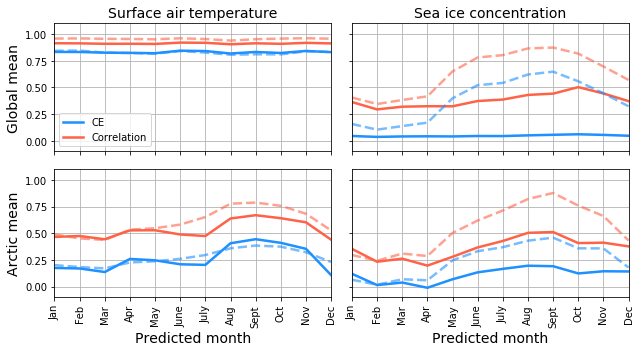

In [59]:
mlabels = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']

fig,ax = plt.subplots(2,len(varplot), figsize=(9,5),sharex=True, sharey=True)
ax = ax.flatten()

for n,var in enumerate(varplot): 
    print(var)
    ax[n].plot(np.arange(1,13,1),ce_monthly[var+'_gm'],color=color_list[1],
             linestyle='-', label='CE', linewidth=2.5)
    ax[n].plot(np.arange(1,13,1),corr_monthly[var+'_gm'],color=color_list[0],
             linestyle='-', label='Correlation', linewidth=2.5)
    ax[n+len(varplot)].plot(np.arange(1,13,1),ce_monthly[var+'_pm'][:,0],color=color_list[1],
             linestyle='-', linewidth=2.5)
    ax[n+len(varplot)].plot(np.arange(1,13,1),corr_monthly[var+'_pm'][:,0],color=color_list[0],
             linestyle='-', linewidth=2.5)
    
for n,var in enumerate(varplot): 
    ax[n].plot(np.arange(1,13,1),ce_mon_ar1[var+'_gm'],color=color_list[1],
             linestyle='--',alpha=0.6, linewidth=2.5)
    ax[n].plot(np.arange(1,13,1),corr_mon_ar1[var+'_gm'],color=color_list[0],
             linestyle='--',alpha=0.6, linewidth=2.5)
    ax[n+len(varplot)].plot(np.arange(1,13,1),ce_mon_ar1[var+'_pm'][:,0],color=color_list[1],
             linestyle='--',alpha=0.6, linewidth=2.5, label='AR(1) CE')
    ax[n+len(varplot)].plot(np.arange(1,13,1),corr_mon_ar1[var+'_pm'][:,0],color=color_list[0],
             linestyle='--',alpha=0.6, linewidth=2.5, label='AR(1) Corr')

ax[0].set_ylabel('Global mean', fontsize=14)
ax[len(varplot)].set_ylabel('Arctic mean', fontsize=14)

for n in np.arange(len(varplot),len(varplot)*2,1):
    ax[n].set_xlabel('Predicted month', fontsize=14)
    ax[n].set_xticks(np.arange(1,13,1))
    ax[n].set_xticklabels(mlabels, rotation=90)

for n,var in enumerate(varplot):
    ax[n].set_title(full_names[var], fontsize=14)

for n in range(2*len(varplot)):
    ax[n].grid(which='both')
    ax[n].set_xlim(1,12)
    ax[n].set_ylim(-0.10,1.1)

ax[0].legend(loc='lower left')
plt.tight_layout()

In [ ]:
truth.shape

#### Spatial Plots: 

In [ ]:
var = 'sic'
lag = 1

ce_lalo = np.zeros((nlat*nlon))
corr_lalo = np.zeros((nlat*nlon))

truth_full = np.nan_to_num(np.reshape(truth_state[0][var+'_full'],
                                      (truth_state[0][var+'_full'].shape[0],nlat*nlon)))
forecast_full = np.nan_to_num(np.reshape(forecast[0][var+'_full'],
                                         (forecast[0][var+'_full'].shape[0],nlat*nlon)))

for s in range(nlat*nlon):
    ce_lalo[s] = LMR_utils.coefficient_efficiency(truth_full[lag:,s],
                                                  forecast_full[lag:,s])
    corr_lalo[s] = np.corrcoef(truth_full[lag:,s],
                               forecast_full[lag:,s])[0,1]

ce_2d = np.reshape(ce_lalo,(nlat,nlon))                           
corr_2d = np.reshape(corr_lalo,(nlat,nlon))  

In [ ]:
fig,ax = plt.subplots(1,2, figsize=(10,4), subplot_kw = arc_proj)
ax = ax.flatten()

lim.sub_arctic_plot(ax[0],fig,corr_2d,lat_2d,lon_2d, minv=-0.2, 
                    maxv=0.2,cmap='bwr')
lim.sub_arctic_plot(ax[1],fig,ce_2d,lat_2d,lon_2d, minv=-0.2, 
                    maxv=0.2,cmap='bwr')

ax[0].set_title('Correlation')
ax[1].set_title('CE')

plt.tight_layout()

In [ ]:
np.nanmin(corr_2d)

In [ ]:
for v,var in enumerate(limvars):
    forecast_3d = np.moveaxis(np.reshape(LIMfd_valid['x_forecast'][0,fields[var],:],[nlat,nlon,12]),-1,0)
    var_rmse_rs = np.moveaxis(np.reshape(rmse[fields[var],:],[nlat,nlon,12]),-1,0)
    var_rmse_rs2 = np.reshape(rmse[fields[var],:].T, [12,nlat,nlon])
    var_error_rs2 = np.reshape(error_mon[fields[var],:].T, [12,nlat,nlon])
    rmse_lalo[var] = np.reshape(rmse[fields[var],:].T, [12,nlat,nlon])
    
    evar_mon_gm[var],_,_ = LMR_utils.global_hemispheric_means(var_error_rs,lat_2d[:,0])
    rmse_mon_gm[var],_,_ = LMR_utils.global_hemispheric_means(var_rmse_rs,lat_2d[:,0])
    rmse_mon_pm[var] = lim.polar_regional_means(var_rmse_rs2,lat_2d[:,0],lon_2d[0,:])
    evar_mon_pm[var] = lim.polar_regional_means(var_error_rs2,lat_2d[:,0],lon_2d[0,:])

In [ ]:
[error_all_mon, 
 error_mon, rmse,
time_ermon] = lim.calc_forecast_error_by_mon(LIMfd_valid['x_forecast'],1, 
                                             truth,E,LIMfd_valid['time_forecast'],
                                             len(limvars),ndof,
                                             E_sic,nmodes,sic_separate=sic_separate)
[error_all_mon_eof, 
 error_mon_eof, rmse_eof, 
 time_ermon2] = lim.calc_forecast_error_by_mon(LIMfd_valid['x_forecast'],1, 
                                               truth, E,LIMfd_valid['time_forecast'],
                                               len(limvars),ndof,
                                               E_sic,nmodes,sic_separate=sic_separate)
rmse2 = np.mean(error_all_mon**2,axis=2)

evar_mon_gm = {}
rmse_mon_gm = {}
evar_mon_pm = {}
rmse_mon_pm = {}
rmse_lalo = {}

for v,var in enumerate(limvars):
    var_error_rs = np.moveaxis(np.reshape(error_mon[fields[var],:],[nlat,nlon,12]),-1,0)
    var_rmse_rs = np.moveaxis(np.reshape(rmse[fields[var],:],[nlat,nlon,12]),-1,0)
    var_rmse_rs2 = np.reshape(rmse[fields[var],:].T, [12,nlat,nlon])
    var_error_rs2 = np.reshape(error_mon[fields[var],:].T, [12,nlat,nlon])
    rmse_lalo[var] = np.reshape(rmse[fields[var],:].T, [12,nlat,nlon])
    
    evar_mon_gm[var],_,_ = LMR_utils.global_hemispheric_means(var_error_rs,lat_2d[:,0])
    rmse_mon_gm[var],_,_ = LMR_utils.global_hemispheric_means(var_rmse_rs,lat_2d[:,0])
    rmse_mon_pm[var] = lim.polar_regional_means(var_rmse_rs2,lat_2d[:,0],lon_2d[0,:])
    evar_mon_pm[var] = lim.polar_regional_means(var_error_rs2,lat_2d[:,0],lon_2d[0,:])

In [ ]:
# compute errors in both the EOF space and full grid point space
err,err_gm = lim.LIM_forecast_error(LIMfd_valid,truth,E,lags,fields,lat_2d,
                                    E_sic,nmodes,sic_separate=sic_separate)

# err_eofs,err_gm_eofs = lim.LIM_forecast_error(LIMfd_valid,np.real(np.matmul(E,x_valid)),
#                                               E,lags,fields,lat_2d,E_sic,nmodes,
#                                               sic_separate=sic_separate)

In [ ]:
LIMfd_valid['x_forecast'].shape, truth.shape

In [ ]:
color_list = ['crimson','b','m','c','orange','k']

for n,var in enumerate(limvars): 
    plt.plot(lags,err_gm[n,:]/valid_variance_full[var+'_gm'],
             color=color_list[n],linestyle='-',label=var+' valid')
#     plt.plot(lags,err_gm_eofs[n,:]/valid_variance_eof[var+'_gm'],
#              color=color_list[n],linestyle='--',label=list(fields.keys())[n]+' valid eofs')

plt.plot([lags[0],lags[-1]],[1,1],'k--')
plt.xlabel('lead time (months)')
plt.ylabel('total error variance')
#plt.ylim(0,1)
plt.legend()
plt.title('LIM normalized global error variance')

In [ ]:
valid_variance_full.keys()

In [ ]:
evar_mon_pm['sic'].shape

In [ ]:
mlabels = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']

plt.plot(range(12),evar_mon_gm['tas']/valid_variance_full['tas_gm'],
         color='crimson',linestyle='-',label='tas GM')
plt.plot(range(12),evar_mon_pm['sic'][0,:]/valid_variance_full['sic_polarm_mon'][0,:],
         color='b',label='sic Arctic (60N)')
    
plt.axhline(1,0,12,color='k',linestyle='--')    
plt.xticks(range(12),mlabels)
plt.xlabel('forecasted month')
plt.ylabel('total error variance')
#plt.ylim(0,1)
plt.legend()
plt.title('LIM normalized error variance')

In [ ]:
#color_list = ['crimson','b']
mlabels = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']

plt.plot(range(12),rmse_mon_gm['tas']/np.sqrt(valid_variance_full['tas_gm_mon']),
         color='crimson',linestyle='-',label='tas GM')
plt.plot(range(12),rmse_mon_pm['sic'][0,:]/np.sqrt(valid_variance_full['sic_polarm_mon'][0,:]),
         color='b',label='sic Arctic (60N)')
plt.plot(range(12),rmse_mon_pm['sic'][1,:]/np.sqrt(valid_variance_full['sic_polarm_mon'][1,:]),
         color='b',linestyle='--',label='sic Antarctic (60N)')
    
plt.axhline(1,0,12,color='k',linestyle='--')    
plt.xticks(range(12),mlabels)
plt.xlabel('forecasted month')
plt.ylabel('Normalized RMSE')
#plt.ylim(0.7,1.01)
plt.legend()
plt.title('LIM performance by month')

In [ ]:
fig,ax = plt.subplots(4,3, figsize=(8,9), subplot_kw = arc_proj)
ax = ax.flatten()

for m in range(12):
    lim.sub_arctic_plot(ax[m],fig,rmse_lalo['sic'][m,:,:]/np.sqrt(valid_variance_full['sic_mon_lalo'][:,:,m]),
                        lat_2d,lon_2d, minv=0.5, maxv=1,cmap='YlGnBu')
    ax[m].set_title(mlabels[m])

plt.tight_layout()

# plt.savefig((save_dir+var_to_extract+'/'+var_to_extract+
#              '_error_arctic_spatial_plots_randtime_eof'+str(nmodes)+'_tau'+
#              str(tau)+'_'+today_date+'.png'),dpi=300)

In [ ]:
sic_rmse.shape

In [ ]:
# plot the coupled EOFs
mode = 0
lim.plot_map_vector(E[var_dict['var1']['var_inds'],mode],lat_2d,lon_2d)
plt.title(list(fields.keys())[0]+' EOF '+str(mode+1))
plt.show()
lim.plot_map_vector(E[var_dict['var2']['var_inds'],mode],lat_2d,lon_2d)
plt.title(list(fields.keys())[1]+' EOF '+str(mode+1))

In [ ]:
LIMd['vec'].shape

In [ ]:
fields

In [ ]:
var1_inds

In [ ]:
# reshape (nx,ntime)
X = np.moveaxis(np.reshape(data_in_sic,[ntime,nlat*nlon]),0,-1) 
print('Original shape: '+str(data_in_sic.shape))
print('Shape of X: '+str(X.shape))

In [ ]:
X_nonan = np.where(np.isnan(X.data),0,X.data)
X_nonan_arctic = X_nonan
X_nonan_arctic[np.where(lat_2d.reshape(nlat*nlon)<0),:] = 0

In [ ]:
plot_map_vector(X_nonan_arctic[:,800].data,lat_2d,lon_2d)

In [ ]:
X_nonan_arctic_mon = np.reshape(X_nonan_arctic,(3240,1001,12))
X_arctic_FMA = X_nonan_arctic_mon[:,:,1:4].reshape(3240,3003) 
X_arctic_ASO = X_nonan_arctic_mon[:,:,7:10].reshape(3240,3003) 

X_arctic_FMA_anom = X_arctic_FMA - np.nanmean(X_arctic_FMA,axis=1)[:,np.newaxis]
X_arctic_ASO_anom = X_arctic_FMA - np.nanmean(X_arctic_ASO,axis=1)[:,np.newaxis]

In [ ]:
var.shape, W.shape, X_check.shape

In [ ]:
var = X_nonan_arctic_mon[:,:,2] - np.nanmean(X_nonan_arctic_mon[:,:,2],axis=1)[:,np.newaxis]
u,s,v,W = calc_eof(var, lat_2d)

# check SVD
print('checking svd (success for True response)...')
X_check = np.matmul(np.matmul(u,np.diag(s)),v)
print(np.allclose(X_check,W*var))

In [ ]:
plot_eigenvalues(s,var_to_extract)

In [ ]:
plot_map_vector(-u[:,0],lat_2d,lon_2d)

In [ ]:
# project data onto a subset of the EOF basis

# EOF basis
if var_to_extract == 'tos':
    E = u[:,1:nmodes+1]
else:
    E = u[:,0:nmodes]

# project---this doesn't work for tos? masked array/nan issue I don't understand
#P = np.matmul(E.T,X)

# alternative from SVD results. recall v is v.T in numpy. 
# NOTE: this is the projection with W weighting, which is not the same as projecting unweighted data

# 7/13/2020: projection of unweighted data; tos doesn't work with this approach
if var_to_extract == 'tos':
    #P_w = np.matmul(np.diag(s[1:nmodes+1]),v[1:nmodes+1,:])
    P = np.matmul(np.diag(s[1:nmodes+1]),v[1:nmodes+1,:])
else:
    #P_w = np.matmul(np.diag(s[0:nmodes]),v[0:nmodes,:])
    P = np.matmul(E.T,var)

In [ ]:
# reconstruct from the limited projection, and compare with the original (error)
check = np.matmul(E,P)
print(np.max(check))
print(check.shape)

# pick a random time to plot
itim = 21

plot_map_vector(var[:,itim],lat_2d,lon_2d,maxv=3)
plt.title('Original')
plt.show()
plot_map_vector(check[:,itim],lat_2d,lon_2d,maxv=3)
plt.title('Limited EOF projection')
plt.show()

In [ ]:
# make sure P has zero mean first !!!
Pzero = np.max(np.abs(np.mean(P,axis=1)))
if Pzero > 1e-6:
    print('warning!!! the projected state does not have zero-mean in the time domain '
         )

In [ ]:
ntrain = 500

In [ ]:
# prepare the data to train and test the LIM. separate data into training the validation sets 
tsamp = P.shape[1]

train_inds = np.arange(0,ntrain)
valid_inds = np.arange(ntrain,tsamp,1)
x_train = P[:,train_inds]
x_valid = P[:,valid_inds]
print('training data shape: ',x_train.shape)
print('validation data shape: ',x_valid.shape)

In [ ]:
# climo standardized variance for error normalization in training and validation (1=no skill)
train_var = np.var(np.matmul(E,x_train),axis=1,ddof=1)
valid_var = np.var(np.matmul(E,x_valid),axis=1,ddof=1)

In [ ]:
nt = x_train.shape[1]
C_1 = np.matmul(x_train[:,tau:],x_train[:,:-tau].T)/(nt-1)
tau

In [ ]:
C1_phys_space = np.matmul(C_1,E.T)

plot_map_vector(C1_phys_space[0,:],lat_2d,lon_2d,maxv=3)
plt.title('lagged_covariance')
plt.show()

In [ ]:
tau = 1

In [ ]:
# train the LIM
LIMd = LIM_train(tau,x_train)

In [ ]:
lags

In [ ]:
# LIM forecasts for a range of monthly values (can specify a list of arbitrary values too)
lags = np.arange(4)
#lags = [0,3,6,12]
ntims = len(lags)

# training data
LIMfd_train = LIM_forecast(LIMd,x_train,lags,E)

# validation data
LIMfd_valid = LIM_forecast(LIMd,x_valid,lags,E)

In [ ]:
LIMfd_train.keys()

In [ ]:
# proper area-weighted global-mean values, including climo variance
LIMfd_train_error_3d = np.reshape(LIMfd_train['error'],[nlat,nlon,ntims])
LIMfd_valid_error_3d = np.reshape(LIMfd_valid['error'],[nlat,nlon,ntims])

[train_gm_err,
 train_nh_err,
 train_sh_err] = LMR_utils.global_hemispheric_means(np.moveaxis(LIMfd_train_error_3d,-1,0),lat_2d[:,0])
[train_gm_var,
 train_nh_var,
 train_sh_var] = LMR_utils.global_hemispheric_means(np.reshape(train_var[:,None],[nlat,nlon]),lat_2d[:,0])
[valid_gm_err,
 valid_nh_err,
 valid_sh_err] = LMR_utils.global_hemispheric_means(np.moveaxis(LIMfd_valid_error_3d,-1,0),lat_2d[:,0])
[valid_gm_var,
 valid_nh_var,
 valid_sh_var] = LMR_utils.global_hemispheric_means(np.reshape(valid_var[:,None],[nlat,nlon]),lat_2d[:,0])


In [ ]:
# plot global-mean normalized error variance
plt.plot(lags,train_nh_err/train_nh_var,'b-',label='train')
plt.plot(lags,valid_nh_err/valid_nh_var,'r-',label='valid')
plt.plot([lags[0],lags[-1]],[1,1],'k--')
plt.xlabel('lead time (months)')
plt.ylabel('total error variance')
plt.legend()
plt.title('LIM normalized global error variance')
#plt.savefig('LIM_error_growth_1_6_12months',dpi=300)

In [ ]:
# plot maps of select forecasts and errors for a chosen lag in months (and time, itime)
ilag = 1
plot_map_vector(LIMfd_train['error'][:,ilag]/train_var,lat_2d,lon_2d,cmap='PuOr_r')
plt.title('Error')
plt.show()
itime = 1
plot_map_vector(np.matmul(E,LIMfd_train['x_forecast'][ilag,:,itime]),lat_2d,lon_2d,minv=-4,maxv=4 )
plt.title('Forecast state')
plt.show()
plot_map_vector(X_nonan_arctic[:,itime],lat_2d,lon_2d,minv=-4,maxv=4)
plt.title('True state')
plt.show()
plot_map_vector(X_nonan_arctic[:,itime] -np.matmul(E,LIMfd_train['x_forecast'][ilag,:,itime]),lat_2d,lon_2d)
plt.title('True - Forecast state')
plt.show()

In [ ]:
forecast_state_train = np.matmul(E,LIMfd_train['x_forecast']) 
true_state_train = X_arctic_FMA[:,train_inds]
true_state_train.shape, forecast_state_train.shape

In [ ]:
initialt = 1
plt.plot(np.arange(0,13,1),true_state_train[3200,initialt:initialt+13], label='truth')
plt.plot(np.arange(0,13,1),forecast_state_train[:,3200,initialt], label='forecast')
plt.legend()

r = np.zeros(4000-12)

for it in range(4000-12):
    r[it] = np.corrcoef(true_state_train[3000,it:it+13],forecast_state_train[:,3000,it])[0,1]

In [ ]:
plt.plot(r)
#plt.xlim(3900,4000)
r.mean()

In [ ]:
LIMfd_train.keys(), x_valid.shape, E.shape, lags

In [ ]:
LIMfd_train['x_truth_phys_space'].shape,LIMfd_train['x_forecast_phys_space'].shape, LIMfd_train['error'].shape, LIMfd_train['x_forecast'].shape

In [ ]:
# proper area-weighted global-mean values, including climo variance
LIMfd_train_truth_3d = np.reshape(LIMfd_train['x_truth_phys_space'],[nlat,nlon,3988])
LIMfd_train_forecast_3d = np.reshape(LIMfd_train['x_forecast_phys_space'],[nlat,nlon,3988])
LIMfd_valid_truth_3d = np.reshape(LIMfd_valid['x_truth_phys_space'],[nlat,nlon,3988])
LIMfd_valid_forecast_3d = np.reshape(LIMfd_valid['x_forecast_phys_space'],[nlat,nlon,3988])

[train_truth_gm,
 train_truth_nh,_] = LMR_utils.global_hemispheric_means(LIMfd_train_truth_3d,lat_2d[:,0])
[train_forecast_gm,
 train_forecast_nh,_] = LMR_utils.global_hemispheric_means(LIMfd_train_forecast_3d,lat_2d[:,0])
[valid_truth_gm,
 valid_truth_nh,_] = LMR_utils.global_hemispheric_means(LIMfd_valid_truth_3d,lat_2d[:,0])
[valid_forecast_gm,
 valid_forecast_nh,_] = LMR_utils.global_hemispheric_means(LIMfd_valid_forecast_3d,lat_2d[:,0])



## Independent validation: 

In [ ]:
# load 20cr data for independent validation...
data_20cr,_,_ = get_data(var_to_extract,infile_20cr_tas, 45, 72)
ntime_20cr = data_20cr.shape[0]

In [ ]:
# back to (nx,ntime)
X_20cr = np.moveaxis(np.reshape(data_20cr,[ntime_20cr,nlat*nlon]),0,-1) 

# test the LIM on 20CR monthly data projected on the same basis
P_20cr = np.matmul(E.T,X_20cr)

# climo standardized variance
valid_var_20cr = np.var(np.matmul(E,P_20cr),axis=1,ddof=1)

In [ ]:
# CCSM LIM forecasts on 20cr states
LIMfd_20cr = LIM_forecast(LIMd,P_20cr,lags,E)

In [ ]:
# proper area-weighted global-mean values
valid_gm_err_20cr,_,_ = LMR_utils.global_hemispheric_means(np.moveaxis(np.reshape(LIMfd_20cr['error'],[nlat,nlon,ntims]),-1,0),lat_2d[:,0])
valid_gm_var_20cr,_,_ = LMR_utils.global_hemispheric_means(np.reshape(valid_var_20cr[:,None],[nlat,nlon]),lat_2d[:,0])


In [ ]:
plt.plot(lags,valid_gm_err/valid_gm_var,'k-',label='ccsm')
plt.plot(lags,valid_gm_err_20cr/valid_gm_var_20cr,'r-',label='20cr')
plt.plot([lags[0],lags[-1]],[1,1],'k--')
plt.xlabel('lead time (months)')
plt.ylabel('total error variance')
plt.legend()
plt.title('LIM normalized global error variance')
#plt.savefig('LIM_forecast_error_ccsm_20cr_6mo',dpi=300)